# SCENARIO 2

Cooperation between countries and optimizes for a balanced system, using costs and environmental aspects
Utilizes the iterative phasing

- Snapshot of 2050
- Eco-Impact as a constraint
- Fishery threshold for aquaculture (only??)
- TSO hubs added and locations are optimized
- 50 GW of solar minimum
- 250 km2 of aquaculture



In [1]:
# Imports
import os
import warnings 
import sys
import importlib
from pathlib import Path 

directory = Path(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))
sys.path.append(str(directory))

modules_to_reload = [
    
    'src.marine_plan.marineplan',
    'src.marine_plan.pre_compute',
    'src.marine_plan.post_compute.clustering',
    'src.marine_plan.post_compute.substations',
    'src.marine_plan.phasing'
]

# Reload and import each module
for module_name in modules_to_reload:
    module = importlib.import_module(module_name)
    importlib.reload(module)
    globals().update({name: getattr(module, name) for name in dir(module) if not name.startswith('_')})

from src.marine_plan.marineplan import *
from src.marine_plan.pre_compute.pre_compute import *
from src.marine_plan.post_compute.clustering import *
from src.marine_plan.post_compute.substations import *
from src.marine_plan.phasing import *


warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
hubs = {
    "sorlige nordsjo 2": {"latitude": 57.853, "longitude": 4.748, "capacity": 3, "country": "NO"},
    "danish": {"latitude": 56.089, "longitude": 5.664, "capacity": 10, "country": "DK"},
    "german": {"latitude": 54.971, "longitude": 6.264, "capacity": 10, "country": "DE"},
    "dutch": {"latitude": 54.122, "longitude": 3.905, "capacity": 10, "country": "NL"},
    "PE zone": {"latitude": 51.550, "longitude": 2.470, "capacity": 3.5, "country": "BE"},
}

set_cables = { 
    "NO-DK": {"from": "sorlige nordsjo 2", "to": "danish", "capacity": 2, 'designation': 'none'},
    "NO-UK": {"from": "sorlige nordsjo 2", "to": "blyth_sub", "capacity": 2, 'designation': 'single'},
    "NO-DE": {"from": "sorlige nordsjo 2", "to": "buttel", "capacity": 2, 'designation': 'single'},
    "NO-BE": {"from": "sorlige nordsjo 2", "to": "zeebrugge_sub", "capacity": 2, 'designation': 'single'},
    "GB-DK": {"from": "danish", "to": "blyth_sub", "capacity": 1.8, 'designation': 'single'},
    "DE-DK": {"from": "german", "to": "danish", "capacity": 2, 'designation': 'none'},
    "DE-NL": {"from": "german", "to": "dutch", "capacity": 2, 'designation': 'none'},
    "BE-NL": {"from": "PE zone", "to": "dutch", "capacity": 2, 'designation': 'none'},
    "LionLink": {"from": "humberside", "to": "dutch", "capacity": 1.8, 'designation': 'single'},
    "Nautilus": {"from": "sizewell", "to": "PE zone", "capacity": 1.4, 'designation': 'single'},
    "TritonLink": {"from": "PE zone", "to": "danish", "capacity": 2, 'designation': 'single'},
    "home_PE zone": {"from": "PE zone", "to": "zeebrugge_sub", "capacity": 3.5, 'designation': 'single'},
    "home_sorlige": {"from": "sorlige nordsjo 2", "to": "norway_1", "capacity": 3, 'designation': 'single'},
    "home_danish": {"from": "danish", "to": "esbjerg_sub", "capacity": 10, 'designation': 'single'},
    "home_german": {"from": "german", "to": "buttel", "capacity": 10, 'designation': 'single'},
    "home_dutch": {"from": "dutch", "to": "wijk_aan_zee", "capacity": 10, 'designation': 'single'},
}


## Simulation environment

goals = {
    'mussel_units':   {'min': 4_500, 'unit': 'turbines', 'penalty': 'exponential'},
    'seaweed_units':     {'min': 4_500, 'unit': 'panels', 'penalty': 'exponential'},
    'fpv_units':     {'min': 1_550, 'unit': 'panels', 'penalty': 'exponential'},
}

sim_env = {'env_name': 'generic_testing',
           'run_name': 'test',
           'config': ['msp'], 
           'result_folder': 'test',
           'goals': goals,
           'hubs': hubs,
           'hubs_included': True,
           'set_cables': set_cables,
           'iterative': True,
           'optimize_hubs': False, #### MUST TWEAK
           'port_limits': False
           }

sim_params = {
    'energy_targets': True,
    'country': 'all', # 'all' or 2 letter country code
    'capacity_needed': 0, # When 'all' is selected, it uses the total capacity calculated from the energy targets dictionary within the class
    'coop': False, # Adjust to True to allow placements outside of EEZ
    'synergies': False, # Deprecated
    'calc_interconnectors': False, # Deprecated
    'hub_constraints': False, # Deprecated
    'eco_limit': 2.5, # The maximum eco sensitivity value that is acceptable
}

## Technology options - if for any reason you want to remove a technology, just set present to False
base_single_techs = {
        'monopile': {'present': True, 'metric_mods': {}},
        'jacket': {'present': True, 'metric_mods': {}},
        'fpv': {'present': True, 'metric_mods': {}},
        'semisub_cat_drag': {'present': True, 'metric_mods': {}},
        'semisub_taut_driv': {'present': True, 'metric_mods': {}},
        'semisub_taut_suc': {'present': True, 'metric_mods': {}},
        'spar_cat_drag': {'present': True, 'metric_mods': {}},
        'spar_taut_driv': {'present': True, 'metric_mods': {}},
        'spar_taut_suc': {'present': True, 'metric_mods': {}},
        'mussel': {'present': True, 'metric_mods': {}},
        'seaweed': {'present': True, 'metric_mods': {}},
  }

optimization_params = {
    'negatives': {
        'total_opex': 1,
        'total_capex': 1,
        # 'total_CO2_emission': 1.5,
        # 'total_eco_sensitivity': 9_000_000, # Ranges from ~ -2 to 3, the lower the number, the better. The only one with negative values (very good) is aquaculture
                                             # 10_000_000 is a placeholder for monetization, basically saying that 1 = 10_000_000€
    },

    'positives': {
        # 'total_energy': 1,
        # 'total_food': 1,
        'total_revenue': 1,
        # 'total_CO2_mitigation': 1.5,
        'total_CO2_net': 1,
        # 'total_LCOE': 1, # the lower the better -- so try to minimize this
        # 'total_eco_sensitivity': 9_000_000,
    },
    
    'direction': 'maximize',
    'solver': 'HiGH',
}

cursed_phasing(directory, sim_env, sim_params, base_single_techs, optimization_params, 100, update_ports=False, custom_ports=True)

All calculations complete.
Temp folder created and filled
Time taken for _load_metrics: 0.2520101070404053 seconds
Time taken for _set_criteria_metrics: 47.64808702468872 seconds
Setting energy targets
Time taken for _set_energy_targets: 6.978610038757324 seconds
Optimization did not find an optimal solution for generic_testing - test -- Infeasible.
Time taken for optimization: 15.724217891693115 seconds


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

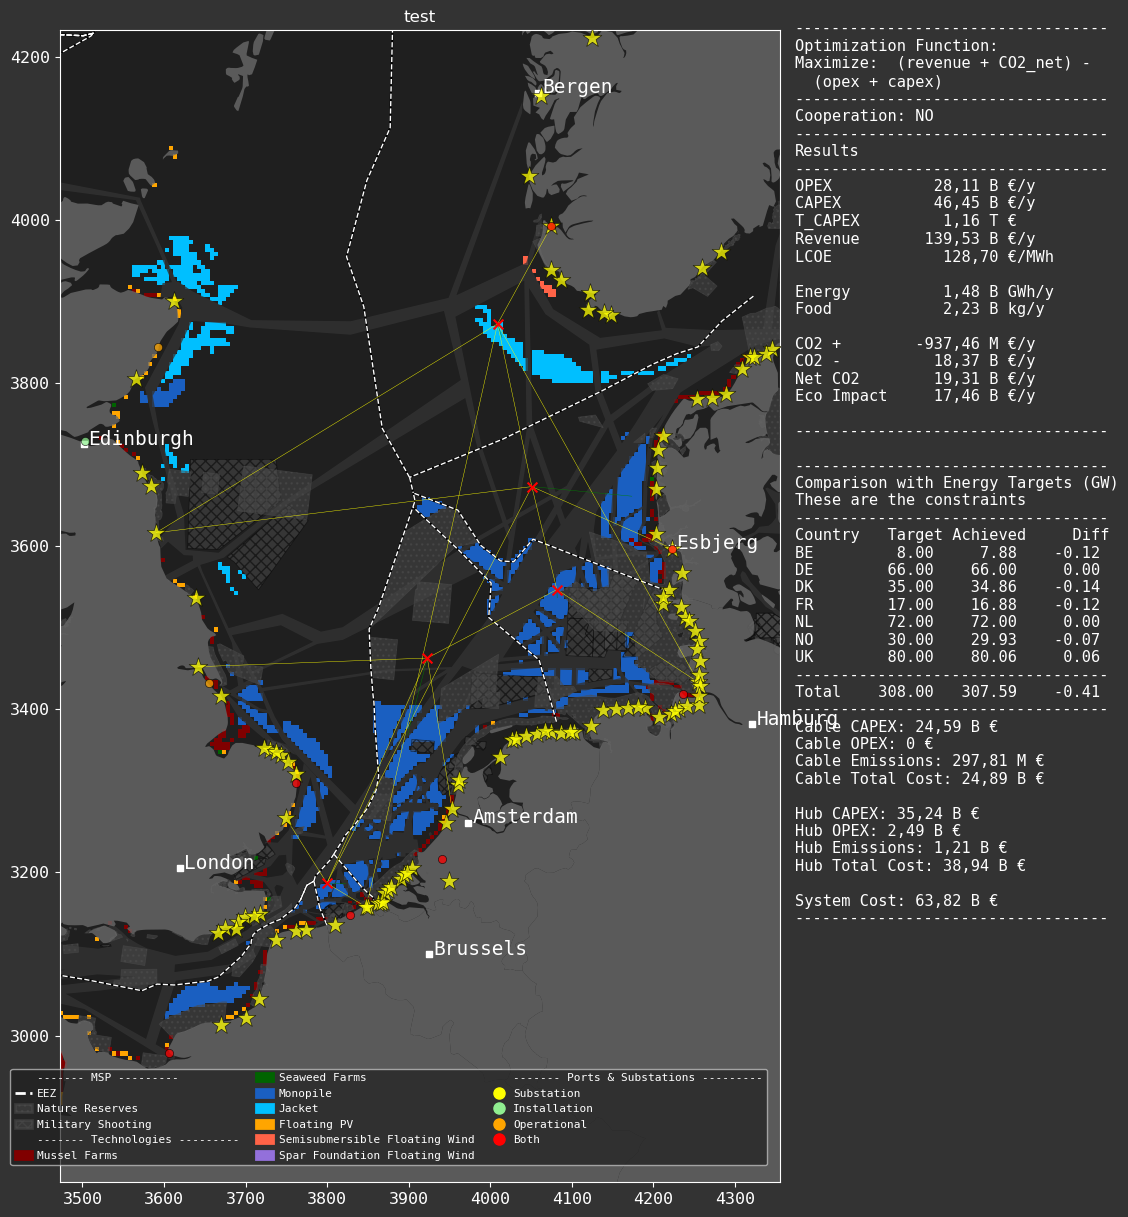

In [3]:
map_CONFIG = {
    'scale': 'international',
    'output_type': 'energy_targets',
    'msp': {
        'shipping': (True, "#333333"),
        'military': (True, "#4D4D4D"),
        'sand_extraction': (False, "#F4A460"),
        'nature_reserves': (True, "#4D4D4D"),
        'energy_zones': (False, "#000000"),
        'energy_zones_type': 'whole_zone',
        'wind_farms': (False, {
            "approved": "#FFD700",
            "planned": "#EEE8AA",
            "under_construction": "#FF7F50",
            "operational": "#008080"
        }),
        'legacy_farms': (False, "#000000"),
        'interconnectors': (False, "#000000"),
        'cables': (False, {
            "IC_to_grid": "red",
            "farm_to_IC": "#FFD700",
            "farm_to_grid": "#808080"
        })
    },
    'colours': {
        'mussel': '#800000',      
        'seaweed': '#006400',    
        'monopile': '#1A5FC1',        
        'jacket': '#00BFFF',           
        'fpv': '#FFA500',           
        'semisub_cat_drag': '#FF6347', 
        'semisub_taut_driv': '#FF6347',
        'semisub_taut_suc': '#FF6347',
        'spar_cat_drag': '#9370DB', 
        'spar_taut_driv': '#9370DB',
        'spar_taut_suc': '#9370DB',
    },
}

P.plot_optimal_solution(map_CONFIG=map_CONFIG)